In [6]:
import torch
import torch.nn as nn
print(torch.cuda.is_available())

class AlexNet(nn.Module):
    # Input = [batch_size, 3, 224, 224]

    def __init__(self):
        super(AlexNet, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.dropout1 = nn.Dropout(p=0.15)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.linear1 = nn.Linear(in_features=5 * 5 * 256, out_features=4096)
        self.linear2 = nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))

        return x

True


# Another Kind of coding is:

In [7]:

# import torch
# from torch import nn
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class AlexNet(nn.Module):
#     def __init__(self):
#         super(AlexNet, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2), # kernel_size, stride
#             # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
#             nn.Conv2d(96, 256, 5, 1, 2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2),
#             # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
#             # 前两个卷积层后不使用池化层来减小输入的高和宽
#             nn.Conv2d(256, 384, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(384, 384, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(384, 256, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2)
#         )
#          # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
#         self.fc = nn.Sequential(
#             nn.Linear(256*5*5, 4096),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
#             nn.Linear(4096, 10),
#         )

#     def forward(self, img):
#         feature = self.conv(img)
#         output = self.fc(feature.view(img.shape[0], -1))
#         return output


**Import for Train and Datasets**

In [8]:
import copy
import os
import time
from datetime import datetime

import pandas as pd
import torch
import torch.utils.data as Data
from matplotlib import pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms

In [9]:
def train_loader():
    dataset = datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([transforms.Resize(size=224), transforms.ToTensor()]))
    train_data, valid_data = Data.random_split(dataset, [round(len(dataset) * 0.8), round(len(dataset) * 0.2)])
    train_data_loader, valid_data_loader = (
        Data.DataLoader(dataset=train_data, batch_size=16, shuffle=True, num_workers=4),
        Data.DataLoader(dataset=valid_data, batch_size=16, shuffle=True, num_workers=4))
    print("Data Loaded.")
    print("{}".format(dataset.classes))
    return train_data_loader, valid_data_loader


def train_model(model, epochs, train_data_loader, valid_data_loader, criterion=nn.CrossEntropyLoss(),
                Optimizer=optim.SGD,
                learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    net_on_device = model.to(device = device)
    optimizer = Optimizer(net_on_device.parameters(), lr=learning_rate, momentum= 0.9)

    best_valid_accuracies = 0
    train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []
    train_loss, valid_loss, train_acc, valid_acc = 0.0, 0.0, 0.0, 0.0
    train_num, valid_num = 0, 0

    for epoch in range(epochs):
        since = time.time()
        print('Time:{}\tEpoch: {}/{}'.format(datetime.now().strftime("%Y%m%d_%H:%M:%S"),epoch, epochs - 1))
        print('-' * 80)
        for batch_idx, (data, target) in enumerate(train_data_loader):
            images, labels = data.to(device), target.to(device)
            net_on_device.train()
            output = net_on_device(images)
            pre_lab = torch.argmax(output, dim=1)
            loss = criterion(output, labels)  # todo Creterion Error!
            train_acc += torch.sum(pre_lab == labels).item()
            train_loss += loss.item() * images.size(0)
            train_num += images.size(0)
            

            # 模型更新, 反向传播
            net_on_device.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_data_loader):
                images, labels = data.to(device), target.to(device)
                net_on_device.eval()
                output = net_on_device(images)
                pre_lab = torch.argmax(output, dim=1)
                loss = criterion(output, labels)
                valid_acc += torch.sum(pre_lab == labels).item()
                valid_loss += loss.item() * images.size(0)
                valid_num += images.size(0)

        train_losses.append(train_loss / train_num)
        train_accuracies.append(train_acc * 100/ train_num)
        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append(valid_acc * 100 / valid_num)
        print('Train Loss : \t\tTrain acc \t-----> {:.5f} : \t\t{:.3f} %'
              .format(train_losses[-1], train_accuracies[-1]))
        print('Val Loss : \t\tVal acc \t-----> {:.5f} : \t\t{:.3f} %'
              .format(valid_losses[-1], valid_accuracies[-1]))

        if valid_accuracies[-1] > best_valid_accuracies:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_valid_accuracies = valid_accuracies[-1]
            # 保存模型的操作移到这里，减少文件I/O
            model_dir = './model'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            model_path = os.path.join(model_dir, f'best_model_1.pth') # _{datetime.now().strftime("%Y%m%d_%H%M%S")}
            torch.save(best_model_wts, model_path)
            print('Better Model Valid Accuracies, Save Model Weight.')

        time_elapsed = time.time() - since
        print('Training complete in {:.2f}s'.format(time_elapsed % 60))
    train_process = pd.DataFrame(data={"epoch": range(epochs),
                                       "train_loss": train_losses,
                                       "train_acc_percent": train_accuracies,
                                       "val_loss": valid_losses,
                                       "val_acc_percent": valid_accuracies
                                      })
    return train_process


def plot_loss_and_acc(dataframe):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['epoch'], dataframe['train_loss'], 'ro-', label="Training Loss")
    plt.plot(dataframe['epoch'], dataframe['val_loss'], 'bs-', label="Validation Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['epoch'], dataframe['train_acc_percent'], 'ro-', label="Training Accuracy")
    plt.plot(dataframe['epoch'], dataframe['val_acc_percent'], 'bs-', label="Validation Accuracy")
    plt.legend()
    plt.show()


Files already downloaded and verified
Data Loaded.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda
Time:20240210_11:46:31	Epoch: 0/99
--------------------------------------------------------------------------------
Train Loss : 		Train acc 	-----> 2.26747 : 		13.290 %
Val Loss : 		Val acc 	-----> 2.10470 : 		22.790 %
Better Model Valid Accuracies, Save Model Weight.
Training complete in 3.29s
Time:20240210_11:47:35	Epoch: 1/99
--------------------------------------------------------------------------------
Train Loss : 		Train acc 	-----> 2.11921 : 		19.834 %
Val Loss : 		Val acc 	-----> 2.03545 : 		25.330 %
Better Model Valid Accuracies, Save Model Weight.
Training complete in 59.02s
Time:20240210_11:48:34	Epoch: 2/99
--------------------------------------------------------------------------------
Train Loss : 		Train acc 	-----> 1.97005 : 		25.841 %
Val Loss : 		Val acc 	-----> 1.87861 : 		31.493 %
Better Model Valid Accuracies, Save Mo

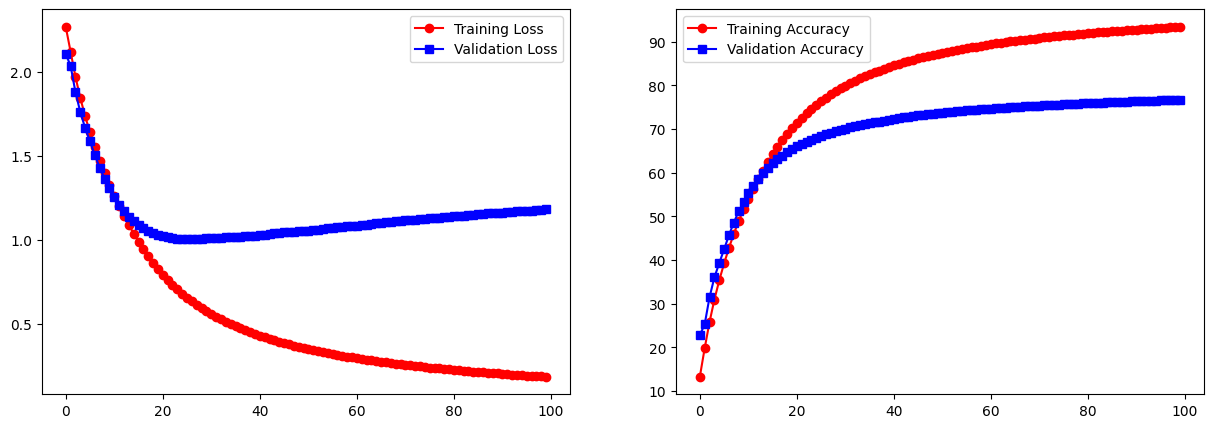

In [10]:
model = AlexNet()
train_loader, val_loader = train_loader()
train_process = train_model(model=model,
                            train_data_loader=train_loader,
                            valid_data_loader=val_loader,
                            epochs=100,
                            learning_rate=0.001,
                            Optimizer=optim.SGD)
plot_loss_and_acc(train_process)
counter = 1
path = './result/'
filename = "train_process.csv"  # 初始文件名应该包括.csv
full_path = os.path.join(path, filename)  # 使用os.path.join来构建完整路径

# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(path):
    os.makedirs(path)

# 检查文件是否存在，如果存在，则更新文件名
while os.path.exists(full_path):
    new_filename = f"train_process({counter}).csv"  # 更新文件名，保证.csv在末尾
    full_path = os.path.join(path, new_filename)  # 更新完整路径
    counter += 1
train_process.to_csv(full_path, index=False)